In [1]:
import os, sys

os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

from scipy import linalg
import stomp_functions as stf
from quspin.operators import hamiltonian, commutator
from quspin.basis import spinful_fermion_basis_general
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from qiskit.quantum_info import random_clifford

1.26.4


In [2]:
# define model parameters
Lx, Ly = 2, 2 # linear dimension of spin 1 2d lattice
N_2d = Lx * Ly # number of sites for spin 1

J = 1.0 # hopping matrix element
U = 2.0 # onsite interaction
mu = 0.5 # chemical potential

In [3]:
# Create symmetry transformations for 2D lattice
s = np.arange(N_2d)
x = s % Lx    # x position of sites
y = s // Lx   # y position of sites

Tx = (x + 1) % Lx + Lx * y   # translation along x direction
Ty = x + Lx * ((y + 1) % Ly) # translation along y-direction
Px = x + Lx * ( Ly - y - 1) # reflection about x-axis
Py = (Lx - x - 1) + Lx * y  # reflection about y-axis
S = -(s + 1) # fermion spin inversion in the simple case

In [4]:
# Define number of up and down fermions in lattice
# We want to be a bit above half-filling here
N_up = N_2d // 2 + 0
N_down = N_2d // 2

# Create basis
basis_2d=spinful_fermion_basis_general(N_2d, Nf=(N_up, N_down), double_occupancy=True,
                                       #kxblock=(Tx,0), kyblock=(Ty,0),
                                       #pxblock=(Px,1), pyblock=(Py,0), # contains GS
                                       #sblock=(S,0)
                                      )
print(basis_2d)

reference states: 
array index   /   Fock state   /   integer repr. 
  0.  |1 1 0 0>|1 1 0 0>  204 
  1.  |1 1 0 0>|1 0 1 0>  202 
  2.  |1 1 0 0>|1 0 0 1>  201 
  3.  |1 1 0 0>|0 1 1 0>  198 
  4.  |1 1 0 0>|0 1 0 1>  197 
  5.  |1 1 0 0>|0 0 1 1>  195 
  6.  |1 0 1 0>|1 1 0 0>  172 
  7.  |1 0 1 0>|1 0 1 0>  170 
  8.  |1 0 1 0>|1 0 0 1>  169 
  9.  |1 0 1 0>|0 1 1 0>  166 
 10.  |1 0 1 0>|0 1 0 1>  165 
 11.  |1 0 1 0>|0 0 1 1>  163 
 12.  |1 0 0 1>|1 1 0 0>  156 
 13.  |1 0 0 1>|1 0 1 0>  154 
 14.  |1 0 0 1>|1 0 0 1>  153 
 15.  |1 0 0 1>|0 1 1 0>  150 
 16.  |1 0 0 1>|0 1 0 1>  149 
 17.  |1 0 0 1>|0 0 1 1>  147 
 18.  |0 1 1 0>|1 1 0 0>  108 
 19.  |0 1 1 0>|1 0 1 0>  106 
 20.  |0 1 1 0>|1 0 0 1>  105 
 21.  |0 1 1 0>|0 1 1 0>  102 
 22.  |0 1 1 0>|0 1 0 1>  101 
 23.  |0 1 1 0>|0 0 1 1>   99 
 24.  |0 1 0 1>|1 1 0 0>   92 
 25.  |0 1 0 1>|1 0 1 0>   90 
 26.  |0 1 0 1>|1 0 0 1>   89 
 27.  |0 1 0 1>|0 1 1 0>   86 
 28.  |0 1 0 1>|0 1 0 1>   85 
 29.  |0 1 0 1>|0 0 1 1>   83 
 

In [5]:
# Set up hamiltonian
hopping_left = [[-J, i, Tx[i]] for i in range(N_2d)] + [[-J, i, Ty[i]] for i in range(N_2d)]
hopping_right = [[+J, i, Tx[i]] for i in range(N_2d)] + [[+J, i, Ty[i]] for i in range(N_2d)]
potential = [[-mu, i] for i in range(N_2d)]
interaction = [[U, i, i] for i in range(N_2d)]

static=[["+-|",hopping_left], # spin up hops to left
		["-+|",hopping_right], # spin up hops to right
		["|+-",hopping_left], # spin down hopes to left
		["|-+",hopping_right], # spin up hops to right
		["n|",potential], # onsite potenial, spin up
		["|n",potential], # onsite potential, spin down
		["n|n",interaction]] # spin up-spin down interaction

In [6]:
# Build the Hamiltonian
H = hamiltonian(static, [], basis=basis_2d, dtype=np.float64).toarray()

Hermiticity check passed!
Symmetry checks passed!


C:\Users\gerar\AppData\Local\Temp\ipykernel_4020\1336399668.py:2: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.basis_general.fermion.spinful_fermion_basis_general'>, to turn off this warning set check_pcon=False in hamiltonian
  H = hamiltonian(static, [], basis=basis_2d, dtype=np.float64).toarray()


In [7]:
# Get eigenvalues
E = linalg.eigvalsh(H)

In [15]:
# Set up evolution params
τ = 5
num_steps = 1500
τs, dτ = np.linspace(0, τ, num_steps, retstep=True)
print(dτ)

0.00333555703802535


In [9]:
# Define files for saving ovlp data
main_path = "2D_FH_clifford_testing/"
ρ_file = main_path + "2DFH_rho_N2d=" + str(N_2d) + "_Nferm=" + str(N_up + N_down) \
            +"_Numsteps=" + str(num_steps) + "_t=" + str(τ) +".npz"

In [10]:
# Generate unitary evolution operator
U = linalg.expm(1j * np.sqrt(dτ / 2) * H)

In [11]:
# Create initial density matrix and evolve using unitary
size = H.shape[0]
strength = 0  # adjust this to control how strong the randomness is

# Identity matrix
ρ = np.eye(size, dtype=complex)

# Add random diagonal
random_diag = strength * (2 * np.random.rand(size) - 1)  # values in [-strength, strength]
ρ += np.diag(random_diag)
# ρ = np.eye(H.shape[0], dtype=complex)
ρ /= np.trace(ρ)
ρs = [ρ]
tr_ρs = [np.trace(ρ)]
tr_ρHs = [np.trace(ρ @ H)]
for i in range(num_steps-1):
    temp = U.conj().T @ ρs[i] @ U.conj().T
    ρs.append(temp)
    tr_ρs.append(np.trace(temp))
    tr_ρHs.append(np.trace(-temp.conj().T @ H))

In [12]:
# Save the overlap data
data = {'z': np.array(tr_ρs), 'O': np.array(tr_ρHs)}
np.savez(ρ_file, **data)

In [13]:
len(tr_ρHs)

1200

C:\Users\gerar\PycharmProjects\ite_propagator\stomp_functions.py:650: RuntimeWarning: divide by zero encountered in scalar divide
  O.append(expt_val / partition)
E:\Anaconda\envs\quantum_env_2\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
E:\Anaconda\envs\quantum_env_2\lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\gerar\PycharmProjects\ite_propagator\stomp_functions.py:650: RuntimeWarning: invalid value encountered in scalar divide
  O.append(expt_val / partition)


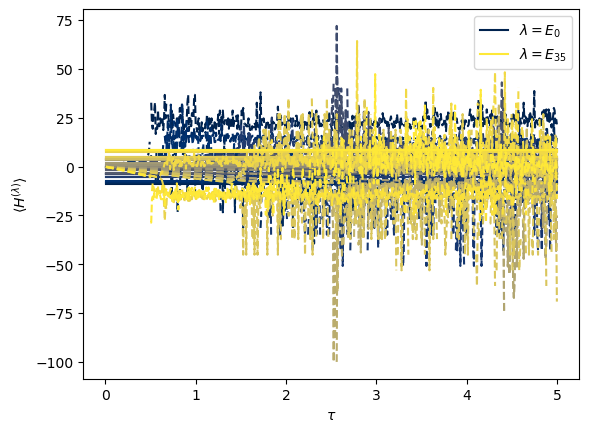

In [14]:
colors = mpl.colormaps['cividis'].resampled(E.size).colors
for i, λ in enumerate(E):
    if i == 0 or i == E.size-1:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors[i],
                 label='$\\lambda=E_{' +str(i) +'}$')
    else:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors[i])
    # plt.plot(τs[2::2], stf.exact_density_partition_calc(tr_ρs, tr_ρHs, num_steps, λ, dτ)[1][1:] - λ,
    #         '--', color=colors[i])    
    plt.plot(τs[2::2], stf.density_partition_calc(tr_ρs, tr_ρHs, num_steps, λ, dτ)[1][1:] - λ,
            '--', color=colors[i])
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle H^{(\\lambda)} \\rangle$")
plt.legend()